In [31]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import feather

from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import stats

from sklearn.linear_model import LinearRegression

import xgboost as xgb

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import json

from tqdm import tqdm_notebook as tqdm


## Loading and setting up the data

In [2]:
se = feather.read_dataframe("../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_offsets_noninterp.feather")
se = se.set_index(se.columns[0])

In [3]:
se = se.dropna(subset=['median_durations_by_segment_code_and_hour_and_day'])



In [4]:
se['prev_timingPoint'] = se['prev_timingPoint'].astype(float).astype(int)

In [5]:
# se.iloc[1978]

In [6]:
def filter_rare(stop_events):

    print("Calculating rare segments...")

    segment_counts = stop_events.groupby("segment_code").size()

    filtered_stop_events = stop_events.drop(
        stop_events[
            stop_events["segment_code"].isin(
                segment_counts[segment_counts < 120].index.values
            )
        ].index
    )

    print("\tCalculated")

    return filtered_stop_events

se = filter_rare(se)

Calculating rare segments...
	Calculated


In [7]:
def MAPE(forecast, actual):
    
    if(len(forecast) != len(actual)):
        raise ValueError('Could not calculate MAPE, forecast and actual arrays are different length')
        
    forecast = np.asarray(forecast)
    actual = np.asarray(actual)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        
        division = (actual-forecast)/actual
        
        division[actual == 0] = 0
        
        # Instead of dividing by n we count by the number of non-zero values. 
        # Essentially ignoring all cases where the actual value is zero. 
        mape = 100 / np.count_nonzero(actual) * np.sum(np.abs(division))
    
    return mape

In [8]:
def make_prediction(medians, results):
    return medians * (1 + (results / 100))




## Adding in a few more medians... why not

Starting by making some more medians to compare

In [46]:
se['dry'] = (se['rain'] == 0)
se['weekend'] = (se['arrival_day'] > 4)

se['weekend'] = se['weekend'].astype(bool)

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [10]:
segment_code_and_hour_and_daytype_groups = se[se["train"]].groupby(
    ["segment_code", "arrival_hour", "weekend"]
)

In [11]:
median_prev_dwell_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    median_prev_dwell_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [12]:
prev_stopCode_and_timing_point_groups = se[se["train"]].groupby(
    ["prev_stopCode", "prev_timingPoint"]
)

median_prev_dwell_by_prev_stop_code_and_timing_point = (
    prev_stopCode_and_timing_point_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_prev_stop_code_and_timing_point")
)

se = se.merge(
    median_prev_dwell_by_prev_stop_code_and_timing_point.to_frame(),
    "left",
    left_on=["prev_stopCode", "prev_timingPoint"],
    right_index=True,
)




In [13]:
segment_code_groups = se[se["train"]].groupby(
    ["segment_code"]
)

median_prev_dwell_by_segment_code = (
    segment_code_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code")
)

se = se.merge(
    median_prev_dwell_by_segment_code.to_frame(),
    "left",
    left_on=["segment_code"],
    right_index=True,
)

In [14]:
se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'] = se['dwell_duration_prev'] - se['median_prev_dwell_by_segment_code_and_hour_and_daytype']



In [15]:
segment_code_and_hour_and_daytype_groups = None
median_prev_dwell_by_segment_code_and_hour_and_daytype = None
prev_stopCode_and_timing_point_groups = None
median_prev_dwell_by_prev_stop_code_and_timing_point = None
segment_code_groups = None
median_prev_dwell_by_segment_code = None


In [16]:
def exclude_columns_containing(se, to_remove):

    min_cols = [c for c in se.columns if not any(x in c for x in to_remove)]

    se_min = se[min_cols]

    return se_min

In [17]:
se = exclude_columns_containing(se, ["prev_segment_code_",
            "next_segment_code_",
            "prev_event_index_",
            "next_event_index_",
            "offset_timestamp_5_", 
            "prev_stop_", 
            "next_stop_",
            "road"])

## Split dwell types into "normal" and not

There is a slight trick going on here. To know how early a bus is we must know it's actual arrival time. This won't be known in advance. So we'll have to estimate how early it's going to be in order to then estimate how long the dwell time is going to be? Is this too much of a hack? 🤔

In [18]:
se['prev_dwell_type_normal'] = True

In [19]:
# If it's a timing point and the bus is early (or even 20 seconds late) treat it as not normal

se.loc[(se['prev_timingPoint'] == 1) & (se['prev_actualArrival'] - pd.Timedelta("20 second") < se['prev_aimedArrival']), 'prev_dwell_type_normal'] = False

In [20]:
if 'median_prev_dwell_by_segment_code_and_hour_and_daytype_normal' in se.columns:
    se = se.drop(columns=['median_prev_dwell_by_segment_code_and_hour_and_daytype_normal'])

segment_code_and_hour_and_daytype_groups_normal = se[(se["train"] == True) & (se['prev_dwell_type_normal'] == True)].groupby(
    ["segment_code", "arrival_hour", "weekend"]
)

median_prev_dwell_by_segment_code_and_hour_and_daytype_normal = (
    segment_code_and_hour_and_daytype_groups_normal["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code_and_hour_and_daytype_normal")
)

se = se.merge(
    median_prev_dwell_by_segment_code_and_hour_and_daytype_normal.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [21]:
#There are only 268 nan's just get rid of them. Should probably replace them with the normal median? 

se = se.dropna(subset=['median_prev_dwell_by_segment_code_and_hour_and_daytype_normal'])

### New feature how early the bus is to the stop

In [22]:
se['how_early'] = (se['prev_aimedArrival'] - se['prev_actualArrival']).astype('<m8[s]')

### Adding in if it's a merged stop

In [23]:
merged_stops = '{"1290BOB20387": ["167_16", "167_125", "167_18", "167_128", "167_21", "167_14", "167_127", "167_116", "167_2", "167_3", "167_115", "167_6", "167_117", "167_118", "167_1", "167_17", "167_15", "167_126", "167_124", "168_1", "168_2", "168_116", "168_3", "168_118", "168_6", "168_117", "168_115", "168_17", "168_126", "168_18", "168_15", "168_16", "168_125", "168_128", "168_21", "168_124", "168_127", "168_14"],"1290BOB20403": ["167_38", "167_44", "167_42", "167_135", "167_137", "167_40", "167_133", "167_134", "167_46", "167_37", "167_51", "167_36", "167_48", "167_23", "167_22", "167_26", "167_130", "167_24", "167_25", "167_28", "167_129", "167_33", "167_132", "167_31", "167_35", "167_32", "167_34", "167_131", "167_45", "167_136", "167_43", "167_41", "167_39", "168_24", "168_25", "168_26", "168_130", "168_22", "168_129", "168_28", "168_23", "168_33", "168_132", "168_35", "168_31", "168_32", "168_34", "168_131", "168_45", "168_43", "168_41", "168_136", "168_134", "168_46", "168_135", "168_137", "168_39", "168_37", "168_51", "168_48", "168_38", "168_40", "168_42", "168_44", "168_133", "168_36", "170_23", "170_22", "170_91", "170_21", "170_25", "170_20", "170_19", "170_90", "170_30", "170_93", "170_28", "170_31", "170_29", "170_92", "170_33", "170_35", "170_36", "170_34", "170_32"],"1280BOB20047": ["167_267", "167_265", "167_264", "167_266", "168_265", "168_264", "168_266", "168_267", "170_217", "170_215", "170_214", "170_216"],"1290BOB20402": ["167_284", "168_284", "170_236"]}'

In [24]:
merged_stops = json.loads(merged_stops)

In [25]:
se['merged_stop_prev'] = False

In [26]:
for stop, patterns in merged_stops.items():
    print(stop)
    print(len(patterns))
    
    se.loc[(se['prev_stopCode'] == stop) & (se['patternId'].isin(patterns)), 'merged_stop_prev'] = True

1290BOB20387
38
1290BOB20403
85
1280BOB20047
12
1290BOB20402
3


## Add a feature to see if it's the first stop of the day (we'll ignore those)

In [79]:
se['first_stop'] = False

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [87]:
firsts = se.reset_index().groupby(['vehicle', 'date']).first()

In [89]:
se.loc[firsts['index'], 'first_stop'] = True

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


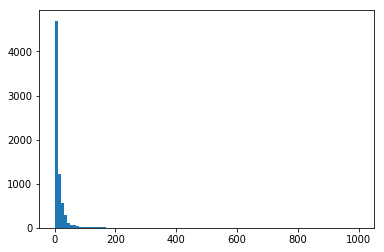

In [74]:
plt.hist(firsts['dwell_duration_prev'], bins=100, range=(0,1000));

In [90]:
np.count_nonzero(se['first_stop'])

7280

index           id      stopCode        aimedArrival  \
vehicle date                                                                 
0       2018-09-26   417831    167_265_1  1280DOB20941 2018-09-26 07:33:00   
        2018-10-17  1419818    167_265_1  1280DOB20941 2018-10-17 07:33:00   
        2018-10-19  1520738   167_2554_1  1290BOB20111 2018-10-19 07:43:00   
        2018-10-24  1729257    168_222_7  1290BOB20446 2018-10-24 13:10:00   
113     2018-09-18    13529    167_222_1  1290BOB20446 2018-09-18 07:55:00   
        2018-09-19    61042    167_218_1  1290DOB21131 2018-09-19 06:12:00   
        2018-09-20   111681    167_217_1  1290DOB21129 2018-09-20 05:43:00   
        2018-09-21   163699    167_218_1  1290DOB21131 2018-09-21 06:12:00   
        2018-09-22   205133    167_113_1  1290BOB20446 2018-09-22 07:15:00   
        2018-09-23   264482    167_191_1  1290DOB21051 2018-09-23 08:35:00   
        2018-09-24   302962    167_217_1  1290DOB21129 2018-09-24 05:43:00   
        2018-09-25   357442    167_223_1  1280BOB20037 2018-09-25 08:01:00   
        2018-09-26   405023    167_223_1  1280BOB20037 2018-09-26 08:01:00   
        2018-09-27   454956    167_218_1  1290DOB21131 2018-09-27 06:12:00   
        2018-09-28   504682    167_217_1  1290DOB21129 2018-09-28 05:43:00   
        2018-09-29   536219    167_117_1  1290DOB21131 2018-09-29 08:54:00   
        2018-10-01   632790    167_219_1  1290DOB21131 2018-10-01 06:42:00   
        2018-10-02   688396    167_221_1  1280BOB20037 2018-10-02 07:31:00   
        2018-10-03   740487    167_221_1  1280BOB20037 2018-10-03 07:31:00   
        2018-10-04   796516    167_222_1  1290BOB20446 2018-10-04 07:55:00   
        2018-10-05   844027  167_1923_19  1290DOB21160 2018-10-05 23:42:00   
        2018-10-08   971656    167_217_1  1290DOB21129 2018-10-08 05:43:00   
        2018-10-09  1025256    167_219_1  1290DOB21131 2018-10-09 06:42:00   
        2018-10-10  1075540    167_221_1  1280BOB20037 2018-10-10 07:31:00   
        2018-10-11  1122990    167_220_1  1280BOB20037 2018-10-11 06:51:00   
        2018-10-12  1169411    167_221_1  1290BOB20003 2018-10-12 07:37:00   
        2018-10-13  1203981    167_112_1  1290DOB21131 2018-10-13 07:24:00   
        2018-10-14  1266593    167_191_1  1290DOB21051 2018-10-14 08:35:00   
        2018-10-19  1514322   167_2522_1  1290DOB21129 2018-10-19 05:43:00   
        2018-10-20  1536173    168_116_1  1280BOB20037 2018-10-20 07:31:00   
...                     ...          ...           ...                 ...   
268     2018-11-03  2185629    168_252_1  1290DOB20885 2018-11-03 07:05:00   
        2018-11-05  2247227    168_160_1  1290DOB21138 2018-11-05 06:55:00   
        2018-11-06  2319203    168_253_1  1290BOB20050 2018-11-06 07:06:00   
        2018-11-07  2363429    170_222_1  1290BOB20293 2018-11-07 07:49:00   
        2018-11-08  2413735    170_213_1  1290BOB20579 2018-11-08 09:38:00   
        2018-11-09  2474269   170_372_12  1290BOB20064 2018-11-09 07:43:00   
        2018-11-13  2641483    170_213_1  1290BOB20579 2018-11-13 09:38:00   
        2018-11-14  2697895    170_213_1  1290BOB20579 2018-11-14 09:38:00   
        2018-11-15  2752041    170_213_1  1290BOB20579 2018-11-15 09:38:00   
        2018-11-16  2804606    170_213_1  1290BOB20579 2018-11-16 09:38:00   
        2018-11-23  2856815    170_218_1  1290DOB20885 2018-11-23 07:05:00   
        2018-11-24  2923538   170_914_13  1290POA11707 2018-11-24 15:49:00   
        2018-11-26  2982802    170_218_1  1290DOB20885 2018-11-26 07:05:00   
        2018-11-27  3054974    170_980_1  1290BOB20087 2018-11-27 07:13:00   
        2018-11-28  3095354    170_218_1  1290DOB20885 2018-11-28 07:05:00   
        2018-11-29  3148819    170_218_1  1290DOB20885 2018-11-29 07:05:00   
        2018-11-30  3200266    170_217_1  1290BOA05936 2018-11-30 06:46:00   
        2018-12-01  3225700    170_121_1  1290BOA90819 2018-12-01 07:42:00   
        2018-12-03  3284579    170_189_1  12

## Adding in the time gap (in seconds) between this bus and the previous and next buses

All based on the previous stop code

In [27]:
se_prev_stopCode_groups = se.groupby(["prev_stopCode"])

In [28]:
se['last_bus_gap'] = np.nan
se['next_bus_gap'] = np.nan

In [32]:
for name, stop in tqdm(se_prev_stopCode_groups):
    
    stop = stop.sort_values("prev_actualArrival")
    
    previous_bus = stop.shift(1)
    next_bus = stop.shift(-1)

    se.loc[stop.index, 'last_bus_gap'] = (stop['prev_actualArrival'] - previous_bus['prev_actualArrival']).astype('<m8[s]')
    se.loc[stop.index, 'next_bus_gap'] = (next_bus['prev_actualArrival'] - stop['prev_actualArrival']).astype('<m8[s]')
    

In [39]:
se = se.dropna(subset=['last_bus_gap', 'next_bus_gap'])
# se['next_bus_gap'] = se['next_bus_gap'].values.astype(float) * 1e-9

/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


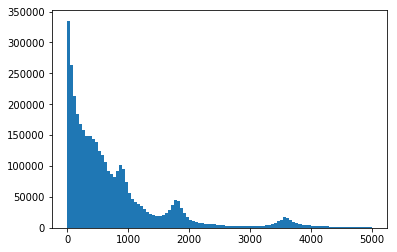

In [33]:
plt.hist(se['last_bus_gap'], bins=100, range=(0, 5000));

In [34]:
np.count_nonzero(np.isnan(se['last_bus_gap']))

860

In [35]:
np.count_nonzero(np.isnan(se['next_bus_gap']))

860

In [ ]:
se['last_bus_recent'] = se['last_bus_gap'] < 30
se['next_bus_soon'] = se['next_bus_gap'] < 30

In [ ]:
np.count_nonzero(np.isnan(se['next_bus_soon']))

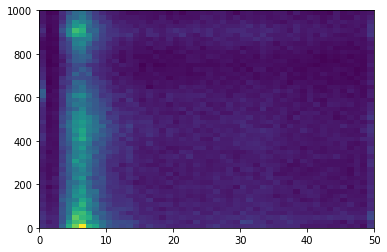

In [65]:
plt.hist2d(se.loc[~se['prev_dwell_type_normal'], 'dwell_duration_prev'], se.loc[~se['prev_dwell_type_normal'], 'next_bus_gap'], bins=[50,50], range=[[0,50],[0,1000]]);


## Making up some rules

In [ ]:
early_timing_points = se[(se['prev_timingPoint'] == 1) & (se['prev_actualArrival'] + pd.Timedelta("1 minute") < se['prev_aimedArrival'])]

In [ ]:
# How many dwell events are timing points and the bus arrives over a minute early

early_timing_points.shape[0]

In [ ]:
plt.hist(early_timing_points['dwell_duration_prev'], bins=100, range=(0,500));

In [ ]:
plt.hist(se.loc[se['prev_timingPoint'] == 1, 'dwell_duration_prev'], bins=100, range=(0,500));

In [ ]:
plt.hist(se.loc[se['prev_timingPoint'] == 0, 'dwell_duration_prev'], bins=100, range=(0,500));

# Looking at correlations between how early a timing point bus is and it's dwell time

In [ ]:
buffers = []
median_dwells = []
mean_dwells = []

for extra in np.linspace(-20, +100, 13):
    dwells = se.loc[(se['prev_dwell_type_normal'] == False) & 
                    (se['how_early'] < extra + 10) &
                    (se['how_early'] > extra),
                        'dwell_duration_prev']
    
    plt.hist(dwells, bins=100, range=(0,500));
    plt.title(f"With {extra} seconds buffer")
    plt.show()
    print(f"With {extra} seconds buffer")
    print(f"Length: {len(dwells):,}")
    print(f"Mean: {np.mean(dwells)}")
    print(f"Median: {np.median(dwells)}")
    print(f"----------------------------------")
    
    buffers.append(extra)
    median_dwells.append(np.median(dwells))
    mean_dwells.append(np.mean(dwells))
    

In [ ]:
buffers = np.array(buffers).reshape(-1, 1) + 5

plt.scatter(buffers, median_dwells, label="medians")
plt.scatter(buffers, mean_dwells, label="means")

reg = LinearRegression()

reg.fit(buffers, median_dwells)

plt.plot(buffers, reg.predict(buffers))
plt.legend()
plt.title("Dwell times for timing point stops where the bus is early")
plt.xlabel("How early the bus is to the nearest 10 seconds")
plt.ylabel("The dwell time (seconds)")
plt.show()

In [ ]:
# So we have a plan. 
# For all non-timing point dwells we do the normal thing (median per stop/segment, hour of the day and day type)
# For all timing points that are late we do normal
# For all timing points that are early between 0 and 90 seconds we do a linear prediction
# For all timing points beyond 90 seconds late we predict 90 seconds
# Easy when you know how... :) 

# This means that we should only train on "normal and early stops"

### Looking at some MAPEs

In [113]:
# Just doing our normal approach is OK...

MAPE(se['median_prev_dwell_by_segment_code_and_hour_and_daytype'], se['dwell_duration_prev'])

84.54851461528679

In [114]:
# But works much better for non-timing points.

MAPE(se.loc[se['prev_timingPoint'] == 0, 'median_prev_dwell_by_segment_code_and_hour_and_daytype'], se.loc[se['prev_timingPoint'] == 0, 'dwell_duration_prev'])

73.74510870342984

In [115]:
# At first this is a confusing result but actually it's expected because all 
# non-timing points are their own segment code so their values are the same 
# in either case

MAPE(se.loc[se['prev_timingPoint'] == 0, 'median_prev_dwell_by_segment_code_and_hour_and_daytype_normal'], se.loc[se['prev_timingPoint'] == 0, 'dwell_duration_prev'])

73.74510870342984

In [116]:
# Extending this to all normal dwells makes it quite a bit worse but still better then before. 

MAPE(se.loc[se['prev_dwell_type_normal'], 'median_prev_dwell_by_segment_code_and_hour_and_daytype_normal'], se.loc[se['prev_dwell_type_normal'], 'dwell_duration_prev'])


78.70939598634187

In [117]:
MAPE([4] * se.shape[0], se['dwell_duration_prev'])

54.60456057059473

In [121]:
for i in np.linspace(4.99,5.01,21):
    print(f"guess: {i}, Mape: {MAPE([i] * se.shape[0], se['dwell_duration_prev'])}")

guess: 4.99, Mape: 52.53496786556488
guess: 4.9910000000000005, Mape: 52.532877367883124
guess: 4.992, Mape: 52.53078687020123
guess: 4.993, Mape: 52.52869637251943
guess: 4.994, Mape: 52.52660587483761
guess: 4.995, Mape: 52.52451537715567
guess: 4.996, Mape: 52.52242487947385
guess: 4.997, Mape: 52.520334381792026
guess: 4.998, Mape: 52.51824388411016
guess: 4.999, Mape: 52.51615338642836
guess: 5.0, Mape: 52.51406288874646
guess: 5.001, Mape: 52.51830074562595
guess: 5.002, Mape: 52.52253860250535
guess: 5.003, Mape: 52.526776459384756
guess: 5.004, Mape: 52.53101431626414
guess: 5.005, Mape: 52.53525217314359
guess: 5.006, Mape: 52.539490030023074
guess: 5.007, Mape: 52.543727886902474
guess: 5.008, Mape: 52.54796574378186
guess: 5.0089999999999995, Mape: 52.55220360066134
guess: 5.01, Mape: 52.55644145754076


In [ ]:
# When tested on only test data ther results are still better than including the non-normal events

MAPE(se.loc[se['test'] & se['prev_dwell_type_normal'], 'median_prev_dwell_by_segment_code_and_hour_and_daytype_normal'], se.loc[se['test'] & se['prev_dwell_type_normal'], 'dwell_duration_prev'])



In [ ]:
MAPE(se.loc[se['prev_timingPoint'] == 0, 'median_prev_dwell_by_segment_code_and_hour_and_daytype_normal'], se.loc[se['prev_timingPoint'] == 0, 'dwell_duration_prev'])


In [ ]:
# Unfortunatly this linear model actually does really poorly when used in the real world.
# This is probably because of the shape of the distribution, actually prediting the median
# Works really badly as very little mass is in the middle, it's double humped.

earlies = se.loc[se['prev_dwell_type_normal'] == False, 'how_early'].values.reshape(-1, 1)


MAPE(reg.predict(earlies), se.loc[se['prev_dwell_type_normal'] == False, 'dwell_duration_prev'])


In [ ]:
plt.hist2d(reg.predict(earlies), se.loc[se['prev_dwell_type_normal'] == False, 'dwell_duration_prev'], bins=[50,50], range=[[0,100],[0,100]]);

In [ ]:
plt.hist(earlies, bins=100, range=(-100,100));

In [ ]:
plt.hist(se.loc[se['prev_dwell_type_normal'] == False, 'dwell_duration_prev'], bins=100, range=(-100,100));

## Trying a richer Linear model

In [91]:
# Remove most of the features and then put back a few we want

for_xg = exclude_columns_containing(se, ["id", 
                                         "date", 
                                         "stopCode", 
                                         "aimed", 
                                         "actual", 
                                         "workid", 
                                         "patternId", 
                                         "publicName", 
                                         "segment_code", 
                                         "segment_name", 
                                         "arrival_5mins",
                                         "full_duration",
                                         "segment_duration",
                                         "dwell",
                                         "self_offset"])

for_xg['median_durations_by_segment_code_and_hour_and_day'] = se['median_durations_by_segment_code_and_hour_and_day']

for_xg['median_prev_dwell_by_segment_code_and_hour_and_daytype'] = se['median_prev_dwell_by_segment_code_and_hour_and_daytype']

for_xg['median_full_durations_by_segment_code_and_hour_and_day'] = se['median_full_durations_by_segment_code_and_hour_and_day']

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [92]:
for_xg.columns

Index(['vehicle', 'scheduledStart', 'timingPoint', 'prev_timingPoint',
       'line_distance', 'to_centre_dist', 'direction', 'direction_degrees',
       'train', 'test', 'rain', 'arrival_hour', 'arrival_day',
       'clock_direction_degrees', 'dry', 'weekend', 'how_early',
       'merged_stop_prev', 'last_bus_gap', 'next_bus_gap', 'first_stop',
       'median_durations_by_segment_code_and_hour_and_day',
       'median_prev_dwell_by_segment_code_and_hour_and_daytype',
       'median_full_durations_by_segment_code_and_hour_and_day'],
      dtype='object')

In [41]:
reg = LinearRegression()

reg.fit(for_xg[for_xg['train'] & (se['prev_dwell_type_normal'] == False)], se.loc[(se['prev_dwell_type_normal'] == False) & se['train'], 'dwell_duration_prev'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [42]:
lin_reg_results = reg.predict(for_xg[se['test'] & (se['prev_dwell_type_normal'] == False)])

MAPE(lin_reg_results, se.loc[(se['prev_dwell_type_normal'] == False) & se['test'], 'dwell_duration_prev'])

263.86516289718315

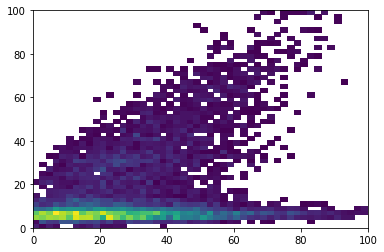

In [43]:
plt.hist2d(lin_reg_results, se.loc[(se['prev_dwell_type_normal'] == False) & se['test'], 'dwell_duration_prev'], bins=[50,50], range=[[0,100],[0,100]], cmin=10);


Linear is still rubbish. In fact just predicting the overal median does slightly better

In [44]:
MAPE([se.loc[(se['prev_dwell_type_normal'] == False) & se['train'], "dwell_duration_prev"].median()] * se.loc[(se['prev_dwell_type_normal'] == False) & se['test']].shape[0],se.loc[(se['prev_dwell_type_normal'] == False) & se['test'], 'dwell_duration_prev'])

210.59346274395807

## Prediciting special dwell times with XGBoost


In [93]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', eval_metric='mae', booster='gbtree', n_jobs=3, max_depth=6, n_estimators=1, verbosity=1)

# xg_reg = xgb.XGBRegressor(objective ='reg:linear', eval_metric='mae', booster='gbtree', n_jobs=5, max_depth=3, n_estimators=10, verbosity=1)

xg_reg.fit(for_xg[for_xg['train'] & (se['prev_dwell_type_normal'] == False)], se.loc[(se['prev_dwell_type_normal'] == False) & se['train'], 'dwell_duration_prev'])

xg_reg.save_model("xg_model_timing_points")

# xg_reg.load_model("models 75days/xg_model_xgboost")

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [94]:
xg_reg_results = xg_reg.predict(for_xg[se['test'] & (se['prev_dwell_type_normal'] == False)])


In [95]:
MAPE(xg_reg_results, se.loc[(se['prev_dwell_type_normal'] == False) & se['test'], 'dwell_duration_prev'])

77.81852345998632

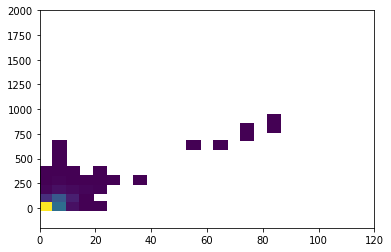

In [96]:
plt.hist2d(xg_reg_results, se.loc[(se['prev_dwell_type_normal'] == False) & se['test'], 'dwell_duration_prev'], bins=[25,25], range=[[0,120],[-200,2000]], cmin=10);


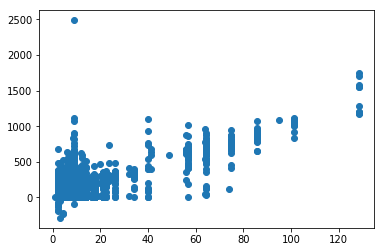

In [97]:
plt.scatter(xg_reg_results, se.loc[(se['prev_dwell_type_normal'] == False) & se['test'], 'dwell_duration_prev'])

In [98]:
feature_importances = xg_reg.feature_importances_

features_sorted = np.argsort(feature_importances)

for i in range(for_xg.shape[1]):
    print(f"{for_xg.columns[features_sorted[i]]} -> {feature_importances[features_sorted[i]]}")

first_stop -> 0.0
timingPoint -> 0.0
prev_timingPoint -> 0.0
next_bus_gap -> 0.0
merged_stop_prev -> 0.0
direction_degrees -> 0.0
train -> 0.0
test -> 0.0
rain -> 0.0
weekend -> 0.0
arrival_day -> 0.0
dry -> 0.0
vehicle -> 0.0014780894853174686
last_bus_gap -> 0.0026683404576033354
arrival_hour -> 0.004763882141560316
line_distance -> 0.008023341186344624
median_durations_by_segment_code_and_hour_and_day -> 0.012731819413602352
scheduledStart -> 0.01431036926805973
direction -> 0.01644240878522396
to_centre_dist -> 0.02416914701461792
clock_direction_degrees -> 0.03492136299610138
median_full_durations_by_segment_code_and_hour_and_day -> 0.035898540169000626
median_prev_dwell_by_segment_code_and_hour_and_daytype -> 0.15772373974323273
how_early -> 0.6868689656257629


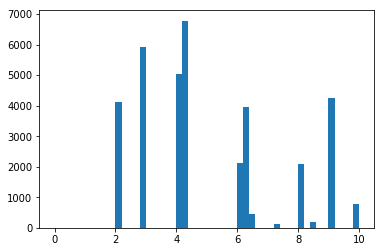

In [99]:
plt.hist(xg_reg_results, bins=50, range=(0,10));

In [100]:
MAPES = []

for i in range(1, 25):
    xg_reg = xgb.XGBRegressor(objective ='reg:linear', eval_metric='mae', booster='gbtree', n_jobs=5, max_depth=i, n_estimators=1, verbosity=1)

    # xg_reg = xgb.XGBRegressor(objective ='reg:linear', eval_metric='mae', booster='gbtree', n_jobs=5, max_depth=3, n_estimators=10, verbosity=1)

    xg_reg.fit(for_xg[for_xg['train'] & (se['prev_timingPoint'] == 1)], se.loc[(se['prev_timingPoint'] == 1) & se['train'], 'dwell_duration_prev'])

    xg_reg_results = xg_reg.predict(for_xg[se['test'] & (se['prev_timingPoint'] == 1)])
    
    mape = MAPE(xg_reg_results, se.loc[(se['prev_timingPoint'] == 1) & se['test'], 'dwell_duration_prev'])
    
    MAPES.append(mape)

    print(f"i:{i} -> MAPE: {mape}")

i:1 -> MAPE: 69.50966221113454
i:2 -> MAPE: 71.92791685255048
i:3 -> MAPE: 74.00299954037479
i:4 -> MAPE: 75.68409116109231
i:5 -> MAPE: 75.92124884921526
i:6 -> MAPE: 76.13763731631258
i:7 -> MAPE: 76.29598278157077
i:8 -> MAPE: 76.39362104460612
i:9 -> MAPE: 76.48669489334452
i:10 -> MAPE: 76.69587798384796
i:11 -> MAPE: 76.85878135460314
i:12 -> MAPE: 77.01160168790788
i:13 -> MAPE: 77.17314879470639
i:14 -> MAPE: 77.42538999443322
i:15 -> MAPE: 77.70691523865747
i:16 -> MAPE: 77.94334198732095
i:17 -> MAPE: 78.27103140863743
i:18 -> MAPE: 78.61991944672832
i:19 -> MAPE: 78.95392401204886
i:20 -> MAPE: 79.34809454821708
i:21 -> MAPE: 79.79188018107423
i:22 -> MAPE: 80.1932228986876
i:23 -> MAPE: 80.64062066061761
i:24 -> MAPE: 81.06984000317617


In [ ]:
plt.plot(range(1,25), MAPES)

In [ ]:
for extra in np.linspace(-20, +100, 13):
    dwells = se.loc[(se['prev_dwell_type_normal'] == False) & 
                    (se['how_early'] < extra + 10) &
                    (se['how_early'] > extra),
                        'dwell_duration_prev']
    
    plt.hist(dwells, bins=100, range=(0,500));
    plt.title(f"With {extra} seconds buffer")
    plt.show()

    rows = for_xg[(for_xg['how_early'] < extra + 10) & (for_xg['how_early'] > extra)]
    
    preds = xg_reg.predict(rows)

    plt.hist(preds, bins=100, range=(0,500), color='red');
    plt.title(f"With {extra} seconds buffer, preds")
    plt.show()
    

It's basically just predicting the spike at the begining. Rubbish. This means it doesn't have enough data to do better. Can we add some? 

## Trying a random forest

In [108]:
rf_reg = xgb.XGBRegressor(
        objective="reg:linear",
        eval_metric="mae",
        booster="gbtree",
        n_jobs=5,
        max_depth=3,
        verbosity=2,
        colsample_bynode=0.8,
        learning_rate=1,
        num_parallel_tree=10,
        subsample=0.8,
        tree_method="hist",
    )

In [109]:
rf_reg.fit(for_xg[for_xg['train'] & (se['prev_dwell_type_normal'] == False)], se.loc[(se['prev_dwell_type_normal'] == False) & se['train'], 'dwell_duration_prev'])

rf_reg.save_model("rf_model_timing_points")



In [110]:
rf_reg_results = rf_reg.predict(for_xg[se['test'] & (se['prev_dwell_type_normal'] == False)])

In [111]:
MAPE(rf_reg_results, se.loc[(se['prev_dwell_type_normal'] == False) & se['test'], 'dwell_duration_prev'])

231.3561030500888

In [112]:
feature_importances = rf_reg.feature_importances_

features_sorted = np.argsort(feature_importances)

for i in range(for_xg.shape[1]):
    print(f"{for_xg.columns[features_sorted[i]]} -> {feature_importances[features_sorted[i]]}")

prev_timingPoint -> 0.0
merged_stop_prev -> 0.0
train -> 0.0
test -> 0.0
rain -> 0.010638728737831116
first_stop -> 0.010924520902335644
arrival_day -> 0.012475485913455486
vehicle -> 0.012553142383694649
weekend -> 0.01306078676134348
median_durations_by_segment_code_and_hour_and_day -> 0.01399522740393877
next_bus_gap -> 0.01416757982224226
arrival_hour -> 0.014256148599088192
scheduledStart -> 0.01588953286409378
last_bus_gap -> 0.017583971843123436
timingPoint -> 0.018877463415265083
clock_direction_degrees -> 0.020862091332674026
dry -> 0.02109219878911972
line_distance -> 0.024388225749135017
direction_degrees -> 0.026377052068710327
direction -> 0.02705862931907177
to_centre_dist -> 0.042944662272930145
median_full_durations_by_segment_code_and_hour_and_day -> 0.055560119450092316
median_prev_dwell_by_segment_code_and_hour_and_daytype -> 0.20746637880802155
how_early -> 0.41982802748680115
